In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')

from datasets.CIFAR_10_Dataset import PROJECT_ROOT, CIFAR_10_Datamodule, CIFAR_10_Dataset, get_heatmaps_grid
from vit_shapley.brute_shap import BruteShap
from vit_shapley.modules.explainer import Explainer
from vit_shapley.modules.surrogate import Surrogate

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(7)

In [2]:
datamodule = CIFAR_10_Datamodule(num_players=16, num_mask_samples=1, paired_mask_samples=False, num_workers=0, batch_size=32)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))
images, labels, _ = data['images'], data['labels'], data['masks']
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


# Loading models

In [3]:
surrogate = Surrogate.load_from_checkpoint(
    PROJECT_ROOT / "saved_models/surrogate/cifar10/v2/player16/vit.ckpt",
    map_location="cuda",
    strict=True
)
surrogate.eval()

use_softmax = False
if use_softmax:
    surrogate = torch.nn.Sequential(
        surrogate,
        torch.nn.Softmax(dim=1),
    )

explainers = {
    "Explainer": Explainer.load_from_checkpoint(
        PROJECT_ROOT / "saved_models/explainer/cifar10/v3/player16/vit.ckpt",
        map_location="cuda",
        surrogate=surrogate,
        strict=True
    )
}
for explainer in explainers.values():
    explainer.eval()

for explainer in explainers.values():
    assert explainer.hparams["use_softmax"] == use_softmax

print(use_softmax)

False


# Compute shap values
With BruteShap this takes ~50 minutes (~1h30 for plain vit).

In [4]:
# For each explainer and for "True", a tensor of shape (len(images), num_players, num_classes).
shap_values = dict[str, torch.Tensor]()

In [5]:
brute_shap = BruteShap(surrogate, num_classes=10)
shap_values["True"] = brute_shap.shap_values(images, num_players=16)  # shape (len(images), num_players, num_classes).

Compute shapley values: 100%|██████████| 16/16 [00:00<00:00, 21.79it/s]


In [13]:
for name, explainer in explainers.items():
    with torch.no_grad():
        shap_values[name] = explainer(images.cuda()).cpu()  # shape (len(images), num_players, num_classes).

In [14]:
# Limit to target class.
target_shap_values = dict[str, torch.Tensor]()
for name in shap_values.keys():
    target_shap_values[name] = shap_values[name][torch.arange(len(images)), :, labels]  # shape (len(images), num_players).

Check whether shapley values summed over players give the proper value (surrogate(unmasked image) - surrogate(fully masked image)).

In [15]:
with torch.no_grad():
    scores = surrogate(images.cuda()).cpu()  # shape (len(images), num_classes).
    scores_zero = surrogate(torch.zeros_like(images).cuda()).cpu()  # shape (len(images), num_classes).
scores_diff = (scores - scores_zero)  # shape (len(images), num_classes).
target_scores_diff = scores_diff[torch.arange(len(images)), labels]  # shape (len(images),)

for name in explainers.keys():
    print(name)
    print((target_scores_diff - target_shap_values[name].sum(dim=1)).abs() < 0.0001)
    print((scores_diff - shap_values[name].sum(dim=1)).abs().max().item())
    print()

Explainer
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])
4.76837158203125e-06



True
min=-0.829, max=2.907


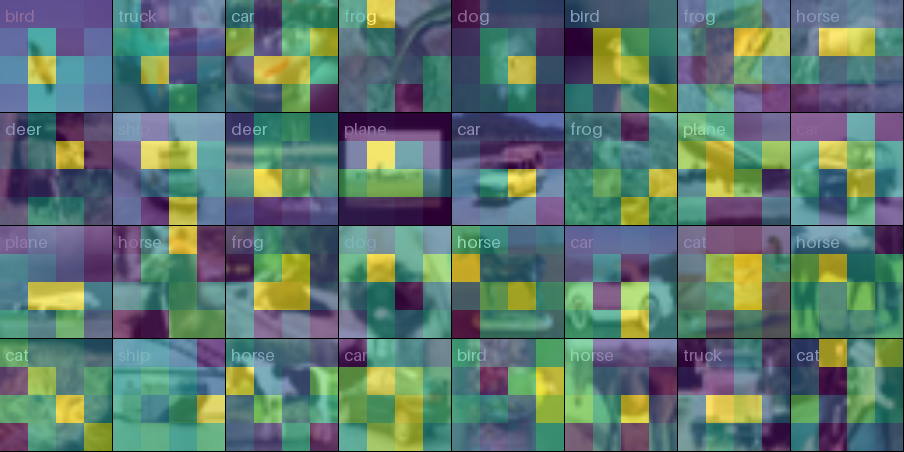


Explainer
min=-0.548, max=2.264


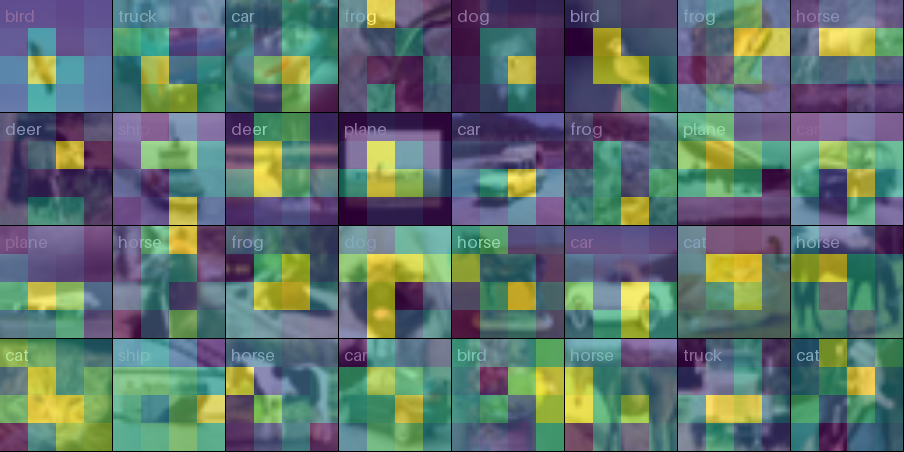

In [16]:
for name in shap_values.keys():
    print(name)
    display(get_heatmaps_grid(images, labels, target_shap_values[name], scale=0.5, alpha=0.6))
    print()

# Check correlations

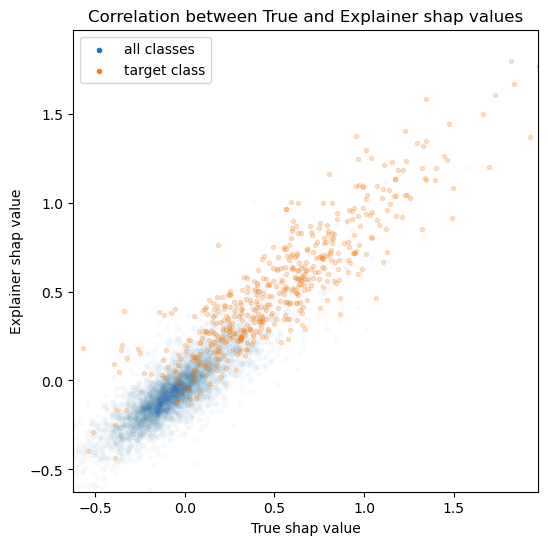

Pearson's correlation coefficient, all classes:  0.91
Pearson's correlation coefficient, target class: 0.91
MAE,  all classes:  0.10
MAE,  target class: 0.15
RMSE, all classes:  0.13
RMSE, target class: 0.20


In [17]:
def pearson(x: torch.Tensor, y: torch.Tensor) -> float:
    correlation_matrix = torch.corrcoef(torch.stack([x.flatten(), y.flatten()]))
    return correlation_matrix[0, 1].item()


def scatter_plot_shap_values(x: str, y: str) -> None:
    plt.figure(figsize=(6, 6))
    plt.title(f"Correlation between {x} and {y} shap values")
    plt.xlabel(f"{x} shap value")
    plt.ylabel(f"{y} shap value")
    plt.scatter(
        shap_values[x].flatten(), shap_values[y].flatten(), marker='.', alpha=0.02, label="all classes"
    )
    plt.scatter(
        target_shap_values[x].flatten(), target_shap_values[y].flatten(),  marker='.', alpha=0.2, label="target class"
    )
    for lh in plt.legend().legend_handles:
        lh.set_alpha(1)

    # Make x and y axes have the same range, excluding outliers:
    q = 0.01
    all_series = [shap_values[x], target_shap_values[x], shap_values[y], target_shap_values[y]]
    lo = min(np.quantile(x, q) for x in all_series)
    hi = max(np.quantile(x, 1 - q) for x in all_series)
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.show()

    print(f"Pearson's correlation coefficient, all classes:  {pearson(shap_values[x], shap_values[y]):.2f}")
    print(f"Pearson's correlation coefficient, target class: {pearson(target_shap_values[x], target_shap_values[y]):.2f}")
    print(f"MAE,  all classes:  {(shap_values[x] - shap_values[y]).abs().mean().item():.2f}")
    print(f"MAE,  target class: {(target_shap_values[x] - target_shap_values[y]).abs().mean().item():.2f}")
    print(f"RMSE, all classes:  {(shap_values[x] - shap_values[y]).pow(2).mean().sqrt().item():.2f}")
    print(f"RMSE, target class: {(target_shap_values[x] - target_shap_values[y]).pow(2).mean().sqrt().item():.2f}")

scatter_plot_shap_values(x="True", y="Explainer")

# Test best/worst/closest/furthest feature masking

In [18]:
from collections import defaultdict
from vit_shapley.modules.explainer_utils import get_masked_accuracy


def scope(num_players: int = 16, batch_size: int = 32, repeats: int = 50) -> None:
    imgs = images.cuda()
    lblbs = labels.cuda()
    results: dict[str, dict[str, list[float]]] = defaultdict(lambda: defaultdict(list))
    # Average over `repeats` executions with different batches of random masks.
    for _ in tqdm(range(repeats)):
        with torch.no_grad():
            masks = CIFAR_10_Dataset.generate_masks(
                num_players=num_players, num_mask_samples=batch_size, paired_mask_samples=True, mode="uniform"
            )
            masks = torch.Tensor(masks).expand(len(images), -1, -1).cuda()
            # shape (len(images), num_mask_samples, num_players).

            for name in shap_values.keys():
                for which in ["best", "worst"]:
                    result = get_masked_accuracy(imgs, masks, lblbs, surrogate, shap_values[name].cuda(), which)
                    results[name][which].append(result)

    for which in ["best", "worst"]:
        for name in shap_values.keys():
            print(f"{name:<10} macc-{which}: {np.mean(results[name][which]):.1f} %")


scope()

  0%|          | 0/50 [00:00<?, ?it/s]

True       macc-best: 70.0 %
Explainer  macc-best: 70.7 %
True       macc-worst: 94.5 %
Explainer  macc-worst: 94.3 %
